# **라이브러리 임포트**

In [1]:
# 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

#
!pip install tensorflow-addons

Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 1.8 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.4
    Uninstalling typeguard-4.4.4:
      Successfully uninstalled typeguard-4.4.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.5.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


In [11]:
# 모델 분석 및 시각화 도구
import os
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import xml.etree.ElementTree as ET
from PIL import Image
from collections import Counter
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage.metrics import structural_similarity as ssim

# Scikit-learn (데이터 전처리 및 모델 평가)
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


# 모델 설계
import tensorflow as tf
from tensorflow.keras.losses import CategoricalFocalCrossentropy

# 모델 구조 및 레이어
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Input, Dense, Conv2D, MaxPooling2D,
Flatten, Dropout, BatchNormalization, Embedding,
LeakyReLU, GlobalAveragePooling2D, concatenate)
from tensorflow.keras.layers import Lambda, Add, Activation, Multiply

# 사전 훈련된 모델
from tensorflow.keras.applications import EfficientNetB0, ResNet50, MobileNetV2, MobileNetV3Small, VGG16, InceptionV3, Xception, DenseNet121

# 컴파일 및 훈련 관련
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

#
from skimage.metrics import structural_similarity as ssim

# **함수 정의**

In [3]:
# 좌표 연속형 10특징 반환 함수
def build_cont_features(xc, yc, bw, bh, wafer_cx, wafer_cy, wafer_r_norm, eps=1e-6):

    # 웨이퍼 중심 기준 좌표
    dx = xc - wafer_cx
    dy = yc - wafer_cy

    # 반경 정규화(0~1)
    dist_norm = np.sqrt(dx*dx + dy*dy)    # 좌표 간 거리
    r_norm = np.clip(dist_norm / max(wafer_r_norm, eps), 0.0, 1.0)    # 정규화

    # 각도(라디안) 및 sin/cos
    theta = np.arctan2(dy, dx)    # 각도
    sin_th = np.sin(theta)
    cos_th = np.cos(theta)

    # 파생특징
    area_norm   = bw * bh                           # 결함의 상대적 크기
    aspect_log  = np.log((bw + eps) / (bh + eps))   # 결함의 종횡비
    edge_margin = 1.0 - r_norm                      # 결함과 가장자리간 거리

    # 중심좌표를 [-1,1] 범위로 스케일(반지름 기준)
    x_centered = np.clip((dx / max(wafer_r_norm, eps)), -1.5, 1.5)
    y_centered = np.clip((dy / max(wafer_r_norm, eps)), -1.5, 1.5)

    # 연속형 특징 저장
    cont = np.array([
        x_centered, y_centered, bw, bh,
        r_norm, sin_th, cos_th, area_norm,
        aspect_log, edge_margin
    ], dtype=np.float32)

    # 출력
    return cont, r_norm, theta

# 좌표값 검증 함수
def validate_coordinates(xc, yc, bw, bh):
    xc = np.clip(xc, 0.0, 1.0)
    yc = np.clip(yc, 0.0, 1.0)
    bw = np.clip(bw, 1e-6, 1.0) # 너비가 0이 되지 않도록
    bh = np.clip(bh, 1e-6, 1.0) # 높이가 0이 되지 않도록
    return xc, yc, bw, bh

# 증강 이미지 품질 검증 함수
def validate_augmentation(original_img, augmented_img, min_ssim=0.7):

    # 이미지를 흑백으로 변환하여 구조적 유사도만 비교
    orig_gray = cv2.cvtColor(original_img, cv2.COLOR_RGB2GRAY)
    aug_gray = cv2.cvtColor(augmented_img, cv2.COLOR_RGB2GRAY)

    # 원본 이미지가 uint8 (0~255)이므로, data_range를 255 설정
    score, _ = ssim(orig_gray, aug_gray, full=True, data_range=255)

    # 점수가 기준치 이상이면 유효한 증강으로 판단
    return score >= min_ssim


def load_original_data_with_base(csv_path, image_root, image_size, fallback_bins=(8,16)):

    # CSV 파일 불러오기
    df = pd.read_csv(csv_path)

    # 정보 저장
    info = ['class','cropped_image','x_center_norm','y_center_norm','width_norm','height_norm']

    # 오류 검증
    for c in info:
        if c not in df.columns:
            raise ValueError(f"CSV에 '{c}' 컬럼이 필요합니다.")

    # 웨이퍼 중심 좌표 저장
    has_wafer = all(c in df.columns for c in ['wafer_cx_norm','wafer_cy_norm','wafer_r_norm'])

    # 리스트 생성
    images, cont_list, rad_bins, sec_bins, labels = [], [], [], [], []

    # 좌표 정보 리스트 생성
    base_coords = []  # (xc, yc, bw, bh, wafer_cx, wafer_cy, wafer_r_norm)


    N_RAD, N_SEC = fallback_bins

    # 결함 패턴에 대한 정보 수집
    for _, row in tqdm(df.iterrows(), total=df.shape[0]):
        img_path = os.path.join(image_root, row['class'], row['cropped_image'])
        img = cv2.imread(img_path)
        if img is None:
            print(f"경고: 이미지를 로드할 수 없습니다 - {img_path}")
            continue

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, image_size)

        xc = float(row['x_center_norm'])    # 바운딩 박스 중심 x 좌표
        yc = float(row['y_center_norm'])    # 바운딩 박스 중심 y 좌표
        bw = float(row['width_norm'])       # 바운딩 박스 밑변
        bh = float(row['height_norm'])      # 바운딩 박스 높이
        wafer_cx = float(row['wafer_cx_norm']) if has_wafer else 0.5    # 웨이퍼 중심 x 좌표
        wafer_cy = float(row['wafer_cy_norm']) if has_wafer else 0.5    # 웨이퍼 중심 y 좌표
        wafer_rn = float(row['wafer_r_norm'])  if has_wafer else 0.5    # 웨이퍼의 반지름

        # 7개의 좌표를 바탕으로 연속형 특징 추출
        cont, r_norm, theta = build_cont_features(xc,yc,bw,bh, wafer_cx,wafer_cy,wafer_rn)

        # 범주형 특징 추출
        if 'rad_bin' in df.columns and 'sec_bin' in df.columns:
            rad_bin = int(row['rad_bin']); sec_bin = int(row['sec_bin'])
        else:
            rad_bin = int(np.clip(np.floor(r_norm * N_RAD), 0, N_RAD-1))
            two_pi = 2*np.pi
            sec_bin = int(np.floor(((theta % two_pi)/two_pi) * N_SEC))

        # 리스트에 저장
        images.append(img)
        cont_list.append(cont)
        rad_bins.append(rad_bin)
        sec_bins.append(sec_bin)
        labels.append(row['class'])
        base_coords.append([xc,yc,bw,bh, wafer_cx,wafer_cy,wafer_rn])

    print(f"-> 원본 데이터 로딩 완료: {len(images)}개 샘플")
    return (np.asarray(images, dtype=np.float32),
            np.asarray(cont_list, dtype=np.float32),
            np.asarray(rad_bins, dtype=np.int32),
            np.asarray(sec_bins, dtype=np.int32),
            np.asarray(labels),
            np.asarray(base_coords, dtype=np.float32))

# 연속형 특징 재계산 함수 ( 증강된 이미지에 대한 좌표 재계산)
def _recompute_cont_from_base(xc, yc, bw, bh, wafer_cx, wafer_cy, wafer_rn):
    cont, r_norm, theta = build_cont_features(xc,yc,bw,bh, wafer_cx,wafer_cy,wafer_rn)
    two_pi = 2*np.pi
    rad_bin = int(np.clip(np.floor(r_norm * 8), 0, 7))
    sec_bin = int(np.floor(((theta % two_pi)/two_pi) * 16))
    return cont, rad_bin, sec_bin


# 데이터 증강 함수
def augment_and_balance_data(
    images, cont_features, rad_bins, sec_bins, labels, base_coords,
    augment_params: dict,
    random_state=42
):
    labels_series = pd.Series(labels)
    class_counts = labels_series.value_counts()
    target_count = class_counts.max()
    print(f"-> 데이터 증강 목표 개수 (각 클래스별): {target_count}")

    # 최종 데이터를 담을 리스트 (원본 데이터로 초기화)
    X_img, X_cont, X_rbin, X_sbin, y = \
        list(images), list(cont_features), list(rad_bins), list(sec_bins), list(labels)

    for cls, count in class_counts.items():
        if count >= target_count:
            continue

        needed = target_count - count
        original_indices = np.where(labels == cls)[0]
        print(f"클래스 '{cls}': {needed}개 증강 시작")

        augmented_count = 0
        while augmented_count < needed:
            idx = np.random.choice(original_indices)

            # 증강의 기반이 될 원본 데이터 선택
            original_image_for_aug = images[idx].copy()
            xc, yc, bw, bh, wcx, wcy, wrn = base_coords[idx]

            # 증강 작업을 수행할 이미지 변수 (원본 복사본으로 시작)
            augmented_img = original_image_for_aug.copy()

            # --- 좌우 반전 ---
            if np.random.rand() < augment_params.get('p_hflip', 0.0):
                augmented_img = np.flip(augmented_img, axis=1) # ⭐ augmented_img 사용
                xc = 1.0 - xc

            # --- 상하 반전 ---
            if np.random.rand() < augment_params.get('p_vflip', 0.0):
                augmented_img = np.flip(augmented_img, axis=0) # ⭐ augmented_img 사용
                yc = 1.0 - yc

            # --- 회전 ---
            if np.random.rand() < augment_params.get('p_rotate', 0.0):
                limit = augment_params.get('rotate_limit', 15)
                angle = np.random.uniform(-limit, limit)
                h, w = augmented_img.shape[:2] # ⭐ augmented_img 사용
                M = cv2.getRotationMatrix2D((w/2, h/2), angle, 1.0)
                augmented_img = cv2.warpAffine(augmented_img, M, (w, h)) # ⭐ augmented_img 사용

                angle_rad = np.radians(angle)
                x_shifted, y_shifted = xc - 0.5, yc - 0.5
                xc_new = x_shifted * np.cos(angle_rad) - y_shifted * np.sin(angle_rad)
                yc_new = x_shifted * np.sin(angle_rad) + y_shifted * np.cos(angle_rad)
                xc, yc = xc_new + 0.5, yc_new + 0.5

            # 증강된 좌표 유효성 검증
            xc, yc, bw, bh = validate_coordinates(xc, yc, bw, bh)

            # --- 밝기/대비 조절 ---
            if np.random.rand() < augment_params.get('p_brightness_contrast', 0.0):
                alpha = 1.0 + np.random.uniform(-0.2, 0.2)
                beta = 10 * np.random.uniform(-1, 1)
                # augmented_img에 적용하고 uint8로 변환
                augmented_img = np.clip(alpha * augmented_img.astype(np.float32) + beta, 0, 255).astype(np.uint8)

            # 증강된 이미지 품질 검증
            if not validate_augmentation(original_image_for_aug, augmented_img):
                continue

            # 변경된 좌표로 모든 파생 특징 재계산
            new_cont, new_rbin, new_sbin = _recompute_cont_from_base(xc, yc, bw, bh, wcx, wcy, wrn)

            # 증강된 데이터를 리스트에 추가
            X_img.append(augmented_img)
            X_cont.append(new_cont)
            X_rbin.append(new_rbin)
            X_sbin.append(new_sbin)
            y.append(cls)

            # 유효한 증강 샘플 카운트 증가
            augmented_count += 1

        print(f"-> 클래스 '{cls}' 증강 완료 (총 {target_count}개)\n")

    # 6. 최종 데이터를 NumPy 배열로 변환하고 섞기
    X_img, X_cont, X_rbin, X_sbin, y = shuffle(
        np.asarray(X_img, dtype=np.uint8),  # 이미지는 uint8로 변환 후 shuffle
        np.asarray(X_cont, dtype=np.float32),
        np.asarray(X_rbin, dtype=np.int32),
        np.asarray(X_sbin, dtype=np.int32),
        np.asarray(y),
        random_state=random_state
    )

    return X_img, X_cont, X_rbin, X_sbin, y


In [4]:
# 모델 학습 결과 시각화 함수
def plot_training_history(history, model_name):

  # 정확도 그래프
  plt.figure(figsize=(14, 5))
  plt.subplot(1, 2, 1)
  plt.plot(history.history['accuracy'], label='Training Accuracy')
  plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
  plt.title(f'{model_name} - Accuracy', fontsize=14)
  plt.xlabel('Epoch', fontsize=12)
  plt.ylabel('Accuracy', fontsize=12)
  plt.legend()
  plt.grid(True)

  # 손실 그래프
  plt.subplot(1, 2, 2)
  plt.plot(history.history['loss'], label='Training Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.title(f'{model_name} - Loss', fontsize=14)
  plt.xlabel('Epoch', fontsize=12)
  plt.ylabel('Loss', fontsize=12)
  plt.legend()
  plt.grid(True)
  plt.tight_layout()
  plt.show()

# 혼동 행렬 시각화 함수
def plot_confusion_matrix(y_true, y_pred_probs, class_names, normalize=False, title='Confusion Matrix'):

  # 확률을 최종 클래스 예측(인덱스)으로 변환
  y_pred_classes = np.argmax(y_pred_probs, axis=1)
  y_true_classes = np.argmax(y_true, axis=1)

  # normalize 옵션 설정
  if normalize:
    # 'true': 실제 라벨(행)을 기준으로 정규화
    cm = confusion_matrix(y_true_classes, y_pred_classes, normalize='true')
    fmt = '.2f' # 소수점 둘째 자리까지 표시
  else:
    cm = confusion_matrix(y_true_classes, y_pred_classes)
    fmt = 'd' # 정수로 표시

  # 혼동 행렬 시각화
  plt.figure(figsize=(9, 8))
  sns.heatmap(
    cm,
    annot=True,
    fmt=fmt, # [개선 2] 포맷 변경
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names
  )

  plt.xlabel('Predicted Class', fontsize=12)
  plt.ylabel('Actual Class', fontsize=12)
  plt.title(title, fontsize=15)
  plt.show()


# **데이터 로드 및 증강**

In [5]:
dataset_path = "/content/drive/MyDrive/ACK2025_Wafer/YOLO/Defect_Pattern_CNN_Dataset"
zip_file_name = "Pattern_Image_Coordinated_Dataset_v5.zip"
unzipped_dataset_path = "Pattern_Image_Coordinated_Dataset_v5"

# Colab 로컬로 데이터셋 이동 및 복사
print("데이터셋을 Colab 로컬 환경으로 복사합니다...")

# 변수를 사용하여 파일 경로를 동적으로 생성
zip_file_path_in_drive = os.path.join(dataset_path, zip_file_name)
!cp "{zip_file_path_in_drive}" /content/
print("압축 해제를 시작합니다...")
!unzip -o -q /content/"{zip_file_name}" -d /content/
print("데이터셋 준비 완료.")

# 로컬 폴더 목록 확인
print("\n/content/ 폴더 내용 확인:")
!ls -l /content/

데이터셋을 Colab 로컬 환경으로 복사합니다...
압축 해제를 시작합니다...
데이터셋 준비 완료.

/content/ 폴더 내용 확인:
total 159424
drwx------  6 root root      4096 Aug 10 14:04 drive
drwxrwxrwx 10 root root      4096 Aug  8 10:43 Pattern_Image_Coordinated_Dataset_v5
-rw-------  1 root root 163229845 Aug 10 14:05 Pattern_Image_Coordinated_Dataset_v5.zip
drwxr-xr-x  1 root root      4096 Aug  7 13:42 sample_data


In [6]:

# 데이터셋 경로 설정 및 이미지 크기 조절
csv_path = os.path.join(dataset_path, "bbox_info_v5.csv")
image_root = os.path.join("/content/", unzipped_dataset_path)
image_size = (128, 128)

# 데이터 로드
images, cont_features, rad_bins, sec_bins, labels, base_coords = load_original_data_with_base(csv_path, image_root, image_size)

# 적용할 데이터 증강 기법과 확률을 딕셔너리로 정의
augment_parameters = {
  'p_hflip': 0.5,
  'p_vflip': 0.5,
  'p_rotate': 0.3,
  'rotate_limit': 20, # -20 ~ +20도 사이에서 회전
  'p_brightness_contrast': 0.4
}

# 증강 함수 호출
X_aug_img, X_aug_cont, X_aug_rbin, X_aug_sbin, y_aug = augment_and_balance_data(
images, cont_features, rad_bins, sec_bins, labels, base_coords, augment_params=augment_parameters)

X_train_final = {
    'image': X_aug_img,
    'continuous': X_aug_cont,
    'radial_bin': X_aug_rbin,
    'sector_bin': X_aug_sbin
}
y_train_final = y_aug

100%|██████████| 6255/6255 [00:15<00:00, 411.21it/s]


-> 원본 데이터 로딩 완료: 6255개 샘플
-> 데이터 증강 목표 개수 (각 클래스별): 1004
클래스 'Edge-Ring': 25개 증강 시작
-> 클래스 'Edge-Ring' 증강 완료 (총 1004개)

클래스 'Loc': 56개 증강 시작
-> 클래스 'Loc' 증강 완료 (총 1004개)

클래스 'Center': 71개 증강 시작
-> 클래스 'Center' 증강 완료 (총 1004개)

클래스 'Random': 150개 증강 시작
-> 클래스 'Random' 증강 완료 (총 1004개)

클래스 'Edge-Loc': 151개 증강 시작
-> 클래스 'Edge-Loc' 증강 완료 (총 1004개)

클래스 'Donut': 470개 증강 시작
-> 클래스 'Donut' 증강 완료 (총 1004개)

클래스 'Near-full': 854개 증강 시작
-> 클래스 'Near-full' 증강 완료 (총 1004개)



In [7]:
# --- 사전 준비: 라벨 데이터를 모델 학습에 맞게 변환 ---
# 1. 문자 라벨 -> 정수 라벨로 변환 (stratify에 사용)
encoder = LabelEncoder()
y_integer_labels = encoder.fit_transform(y_train_final)

# 2. 정수 라벨 -> 원-핫 인코딩 (모델의 최종 출력과 비교할 때 사용)
# 예: 3개의 클래스가 있다면 [0, 1, 2] -> [[1,0,0], [0,1,0], [0,0,1]]
y_categorical_labels = to_categorical(y_integer_labels)


# --- 데이터 분리 (Train/Test Split) ---
# 1. 분리할 모든 입력 데이터와 라벨을 함수에 전달합니다.
X_img_train, X_img_test, \
X_cont_train, X_cont_test, \
X_rbin_train, X_rbin_test, \
X_sbin_train, X_sbin_test, \
y_train, y_test = train_test_split(
    X_train_final['image'],
    X_train_final['continuous'],
    X_train_final['radial_bin'],
    X_train_final['sector_bin'],
    y_categorical_labels,  # 분리할 라벨 데이터 (원-핫 인코딩된 형태)
    test_size=0.2,
    random_state=42,
    stratify=y_integer_labels  # ★분포 유지를 위해서는 정수 라벨을 사용
)

# 정수 라벨을 원-핫 인코딩합니다.
NUM_CLASSES = len(encoder.classes_)

# 2. 분리된 데이터를 다시 딕셔너리로 묶어주면 관리가 편합니다.
X_train = {
    'image': X_img_train,
    'continuous': X_cont_train,
    'radial_bin': X_rbin_train,
    'sector_bin': X_sbin_train
}


X_test = {
    'image': X_img_test,
    'continuous': X_cont_test,
    'radial_bin': X_rbin_test,
    'sector_bin': X_sbin_test
}


# --- 분리 결과 확인 ---
print("데이터 분리 완료!")
print(f"훈련 데이터 개수: {len(X_train['image'])}")
print(f"테스트 데이터 개수: {len(X_test['image'])}")

# 클래스 분포 확인
print("\n훈련 데이터셋의 클래스 분포:")
y_train_int_labels = np.argmax(y_train, axis=1)
print(pd.Series(encoder.inverse_transform(y_train_int_labels)).value_counts())

print("\n테스트 데이터셋의 클래스 분포:")
y_test_int_labels = np.argmax(y_test, axis=1)
print(pd.Series(encoder.inverse_transform(y_test_int_labels)).value_counts())

데이터 분리 완료!
훈련 데이터 개수: 6425
테스트 데이터 개수: 1607

훈련 데이터셋의 클래스 분포:
Donut        804
Edge-Loc     803
Near-full    803
Loc          803
Center       803
Scratch      803
Edge-Ring    803
Random       803
Name: count, dtype: int64

테스트 데이터셋의 클래스 분포:
Edge-Ring    201
Edge-Loc     201
Near-full    201
Center       201
Loc          201
Scratch      201
Random       201
Donut        200
Name: count, dtype: int64


In [8]:
unique_classes = encoder.classes_
num_classes = len(unique_classes)

# **모델 훈련 (ResNet50)**

In [9]:
# 입력층
image_input = Input(shape=(128, 128, 3), name='image')
continuous_input = Input(shape=(10,), name='continuous')
rad_bin_input = Input(shape=(1,), name='radial_bin')
sec_bin_input = Input(shape=(1,), name='sector_bin')


# --- 이미지 처리 브랜치 ---

# ResNet50 모델 로드
base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=image_input)

# 사전 훈련된 모델의 가중치 동결
base_model.trainable = False

# ResNet50 모델의 출력에 새로운 분류층 추가
x_img = base_model.output
x_img = GlobalAveragePooling2D()(x_img)         # 채널별 평균값을 계산하여 벡터로 만듭니다.
x_img = Dense(128, activation='relu')(x_img)
image_features = Dropout(0.5)(x_img)            # 과적합 방지를 위한 드롭아웃


# --- 연속형 특징 처리 브랜치 ---

# 연속형 특징 처리 브랜치
branch0 = Lambda(lambda feat: tf.concat([
        feat[:, :7],  # 기본 좌표 특징들
        tf.math.log1p(tf.maximum(feat[:, 7:8], 1e-6)),  # area_norm 로그변환
        feat[:, 8:9],  # aspect_log (이미 로그)
        feat[:, 9:]   # edge_margin
    ], axis=-1))(continuous_input)

#
branch1 = Dense(64, activation='relu')(branch0)
branch1 = BatchNormalization()(branch1)
branch1 = Dropout(0.2)(branch1)
branch1 = Dense(32, activation='relu')(branch1)

# 잔차 연결
branch2 = Dense(32, activation='relu')(branch0)
branch2 = BatchNormalization()(branch2)
residual = Dense(32, activation=None)(branch0)  # 잔차
branch2 = Add()([branch2, residual])
branch2 = Activation('relu')(branch2)

r_area = Multiply()([
      Lambda(lambda branch0: branch0[:, 4:5])(branch0),  # r_norm
      Lambda(lambda branch0: branch0[:, 7:8])(branch0)   # area_norm (변환된)
    ])
angle_interaction = Multiply()([
      Lambda(lambda branch0: branch0[:, 5:6])(branch0),  # sin_theta
      Lambda(lambda branch0: branch0[:, 6:7])(branch0)   # cos_theta
    ])
interactions = concatenate([r_area, angle_interaction])
branch3 = Dense(16, activation='relu')(interactions)

# 최종 융합
continuous_features = concatenate([branch1, branch2, branch3])



# --- 범주형 특징 처리 브랜치 ---

# 임베딩 층
rad_bin_features = Embedding(input_dim=8, output_dim=4)(rad_bin_input)
rad_bin_features = Flatten()(rad_bin_features)  # 임베딩 결과를 1차원 벡터로 만듭니다.

sec_bin_features = Embedding(input_dim=16, output_dim=8)(sec_bin_input)
sec_bin_features = Flatten()(sec_bin_features)


# 최적 임베딩 차원 계산 (경험적 공식)
rad_embed_dim = min(8, (8 // 2) + 1)  # 5차원
sec_embed_dim = min(12, (16 // 2) + 1)  # 9차원

# 정규화가 포함된 임베딩
rad_embed = Embedding(
    input_dim=8,
    output_dim=rad_embed_dim,
    embeddings_regularizer=tf.keras.regularizers.l2(0.001),
    name='rad_embedding'
  )(rad_bin_input)
rad_flat = Flatten()(rad_embed)

sec_embed = Embedding(
        input_dim=16,
        output_dim=sec_embed_dim,
        embeddings_regularizer=tf.keras.regularizers.l2(0.001),
        name='sec_embedding'
    )(sec_bin_input)
sec_flat = Flatten()(sec_embed)

# 위치 정보 보존을 위한 추가 특징
# 극좌표 특성을 고려한 위치 인코딩
rad_pos = Lambda(lambda x: tf.cast(x, tf.float32) / 8.0)(rad_bin_input)  # 정규화
sec_angle = Lambda(lambda x: tf.cast(x, tf.float32) * 2 * 3.14159 / 16.0)(sec_bin_input)
sec_sin = Lambda(lambda x: tf.sin(x))(sec_angle)
sec_cos = Lambda(lambda x: tf.cos(x))(sec_angle)

pos_features = concatenate([rad_pos, sec_sin, sec_cos])  # 3차원
pos_encoded = Dense(8, activation='relu')(pos_features)

# 임베딩 후 추가 처리
rad_processed = Dense(8, activation='relu')(rad_flat)
rad_processed = BatchNormalization()(rad_processed)

sec_processed = Dense(12, activation='relu')(sec_flat)
sec_processed = BatchNormalization()(sec_processed)

# 모든 범주형 특징 융합
categorical_features = concatenate([rad_processed, sec_processed, pos_encoded])






# --- 브랜치 결합 및 최종 분류층 ---

# 모든 좌표 정보 결합
context_vector = concatenate([continuous_features, categorical_features])
context_vector = Dense(128, activation='relu')(context_vector) # 차원 조절 및 비선형성 추가

# 문맥 벡터를 이용해 이미지 특징의 가중치 계산
attention_weights = Dense(128, activation='sigmoid', name='attention_weights')(context_vector)

# 이미지 특징에 어텐션 가중치 적용
attended_image_features = Multiply()([image_features, attention_weights])

# 최종 정보 결합
combined = concatenate([attended_image_features, context_vector])

# 최종 분류층
x = Dense(64, activation='relu')(combined)
x = Dropout(0.5)(x)
output = Dense(NUM_CLASSES, activation='softmax', name='output')(x)


# --- 컴파일, 훈련 ---

# 최종 모델 생성
model_resnet50 = Model(
    inputs=[image_input, continuous_input, rad_bin_input, sec_bin_input],
    outputs=output
)

# 모델 컴파일
optimizer = Adam(learning_rate=0.0001)
model_resnet50.compile(
    optimizer=optimizer,
    loss=CategoricalFocalCrossentropy(), # Keras 내장 Focal Loss 사용
    metrics=['accuracy']
)

# 모델 전체 구조 출력
model_resnet50.summary()


# 모델 훈련
history_resnet50 = model_resnet50.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)  │ (None, 128, 128,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 134, 134,  │          0 │ image[0][0]       │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 64, 64,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 64, 64,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 64, 64,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 66, 66,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 32, 32,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 32, 32,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 32, 32,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 32, 32,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 32, 32,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 32, 32,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 32, 32,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 32, 32,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 32, 32,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_3_c

 Total params: 23,901,800 (91.18 MB)

 Trainable params: 313,856 (1.20 MB)

 Non-trainable params: 23,587,944 (89.98 MB)

Epoch 1/100
201/201 ━━━━━━━━━━━━━━━━━━━━ 46s 125ms/step - accuracy: 0.3020 - loss: 0.3788 - val_accuracy: 0.7492 - val_loss: 0.1593
Epoch 2/100
201/201 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.6106 - loss: 0.1797 - val_accuracy: 0.8314 - val_loss: 0.0950
Epoch 3/100
201/201 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - accuracy: 0.6969 - loss: 0.1300 - val_accuracy: 0.8650 - val_loss: 0.0649
Epoch 4/100
201/201 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.7524 - loss: 0.1045 - val_accuracy: 0.8811 - val_loss: 0.0495
Epoch 5/100
201/201 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.8005 - loss: 0.0861 - val_accuracy: 0.8923 - val_loss: 0.0445
Epoch 6/100
201/201 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.8220 - loss: 0.0745 - val_accuracy: 0.8973 - val_loss: 0.0415
Epoch 7/100
201/201 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - accuracy: 0.8273 - loss: 0.0712 - val_accuracy: 0.9004 - val_loss: 0.0385
Epoch 8/100
201/201 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - accuracy: 0.8384 - loss: 0.0636 

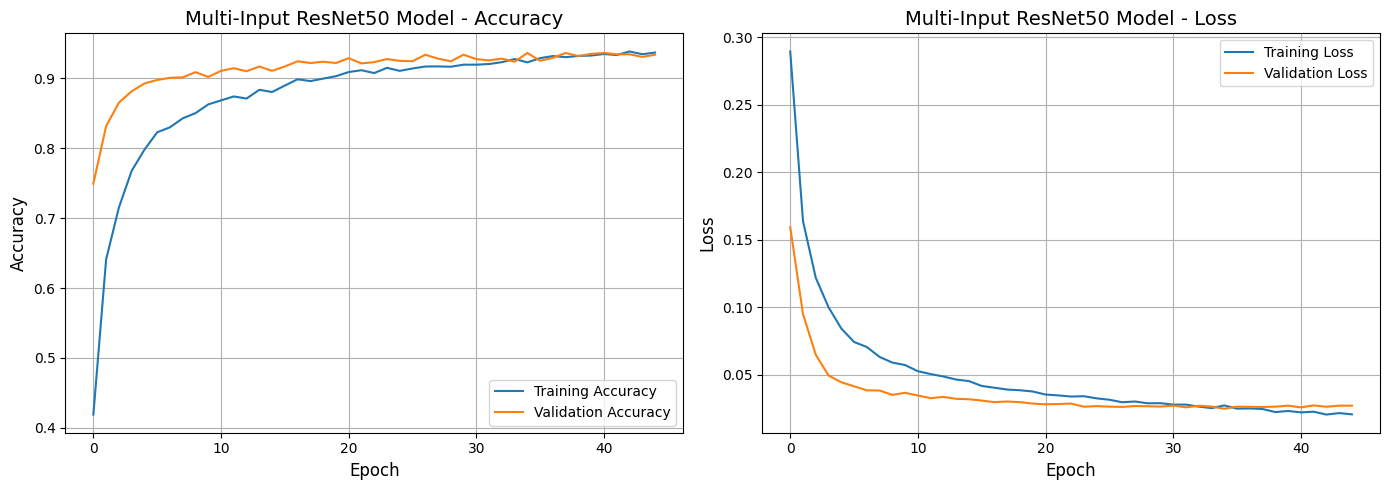

51/51 ━━━━━━━━━━━━━━━━━━━━ 10s 116ms/step


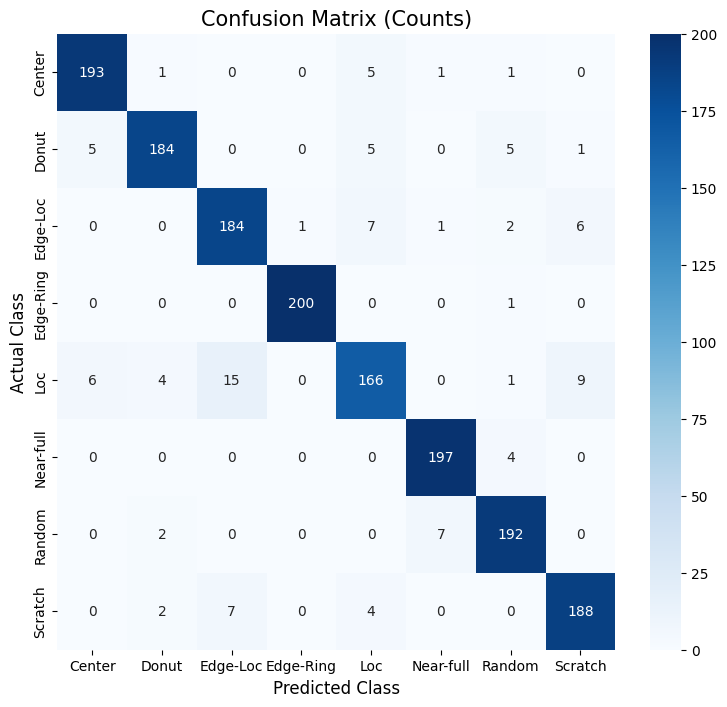

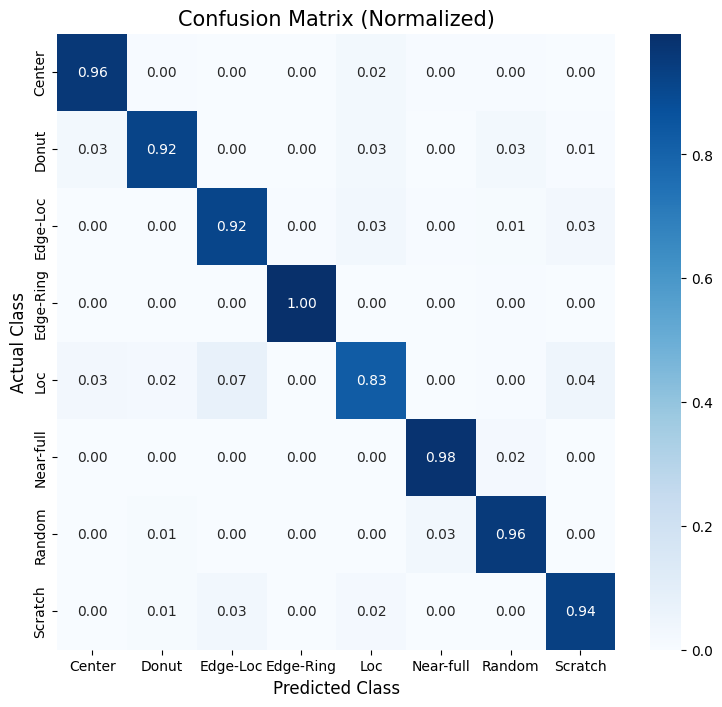

In [10]:
# 훈련 모델 성능 시각화
plot_training_history(history_resnet50, "Multi-Input ResNet50 Model")

# 테스트 데이터로 예측 수행
y_pred_probs = model_resnet50.predict(X_test)

# 혼동 행렬 시각화
plot_confusion_matrix(y_test, y_pred_probs, encoder.classes_, normalize=False, title='Confusion Matrix (Counts)')

plot_confusion_matrix(y_test, y_pred_probs, encoder.classes_, normalize=True, title='Confusion Matrix (Normalized)')

In [12]:
# 원-핫 인코딩된 라벨을 다시 정수 라벨로 변환
y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(y_pred_probs, axis=1)

# --- 1. 전체 평균 성능 계산 ---
accuracy  = accuracy_score(y_true, y_pred)
# 'weighted' 옵션: 클래스별 샘플 수에 따라 가중 평균을 계산하여 불균형을 보정
precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall    = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1        = f1_score(y_true, y_pred, average='weighted', zero_division=0)

print("--- Overall Model Performance ---")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")


# --- 2. 클래스별 개별 성능 계산 ---
# average=None 옵션을 주면 각 클래스별 점수를 배열로 반환
precision_per_class = precision_score(y_true, y_pred, average=None, zero_division=0)
recall_per_class    = recall_score(y_true, y_pred, average=None, zero_division=0)
f1_per_class        = f1_score(y_true, y_pred, average=None, zero_division=0)

# 결과를 보기 좋게 DataFrame으로 정리
class_performance_df = pd.DataFrame({
    'Class': encoder.classes_,
    'Precision': precision_per_class,
    'Recall': recall_per_class,
    'F1-Score': f1_per_class
})

print("\n--- Performance by Class ---")
display(class_performance_df)

--- Overall Model Performance ---
Accuracy:  0.9359
Precision: 0.9357
Recall:    0.9359
F1-Score:  0.9355

--- Performance by Class ---


,Class,Precision,Recall,F1-Score
0,Center,0.946078,0.960199,0.953086
1,Donut,0.953368,0.920000,0.936387
2,Edge-Loc,0.893204,0.915423,0.904177
3,Edge-Ring,0.995025,0.995025,0.995025
4,Loc,0.887701,0.825871,0.855670
5,Near-full,0.956311,0.980100,0.968059
6,Random,0.932039,0.955224,0.943489
7,Scratch,0.921569,0.935323,0.928395
